In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/OpenMP_7.csv")


In [3]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["problemSize"] = dataFrame["problemSize"].astype(int)
dataFrame["numThreads"] = dataFrame["numThreads"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Problem sizes:", sorted(dataFrame["problemSize"].unique()))
print("Thread counts:", sorted(dataFrame["numThreads"].unique()))
dataFrame.head(8)


Loaded rows: 420
Modes: ['reduction' 'atomic' 'critical' 'lock']
Problem sizes: [500000, 1000000, 5000000]
Thread counts: [1, 2, 4, 6, 8, 16, 32]


,testType,problemSize,numThreads,mode,timeSeconds,globalSum,runIndex,ompEnv
0,OpenMP_7,500000,1,reduction,0.000330,125447.0,1,OMP_NUM_THREADS=1
1,OpenMP_7,500000,1,reduction,0.000369,124894.0,2,OMP_NUM_THREADS=1
2,OpenMP_7,500000,1,reduction,0.000334,125088.0,3,OMP_NUM_THREADS=1
3,OpenMP_7,500000,1,reduction,0.000327,125083.0,4,OMP_NUM_THREADS=1
4,OpenMP_7,500000,1,reduction,0.000325,125050.0,5,OMP_NUM_THREADS=1
5,OpenMP_7,500000,2,reduction,0.000316,125205.0,1,OMP_NUM_THREADS=2
6,OpenMP_7,500000,2,reduction,0.000347,125025.0,2,OMP_NUM_THREADS=2
7,OpenMP_7,500000,2,reduction,0.000323,125153.0,3,OMP_NUM_THREADS=2


In [4]:
groupedFrame = dataFrame.groupby(["mode","problemSize","numThreads"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["mode","problemSize","numThreads"]).reset_index(drop=True)
groupedFrame.head(12)


,mode,problemSize,numThreads,median,mean,std,count
0,atomic,500000,1,0.001712,0.001711,0.000002,5
1,atomic,500000,2,0.008380,0.008513,0.000419,5
2,atomic,500000,4,0.012430,0.011759,0.001518,5
3,atomic,500000,6,0.015467,0.016178,0.002155,5
4,atomic,500000,8,0.019717,0.020107,0.003060,5
5,atomic,500000,16,0.031975,0.032034,0.000884,5
6,atomic,500000,32,0.031878,0.032083,0.002344,5
7,atomic,1000000,1,0.003409,0.003459,0.000115,5
8,atomic,1000000,2,0.013171,0.011770,0.002931,5
9,atomic,1000000,4,0.026697,0.026166,0.001867,5


In [5]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    for (modeVal, problemSizeVal), subFrame in groupedDf.groupby(["mode","problemSize"]):
        baseRows = subFrame[subFrame["numThreads"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = subFrame.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numThreads"]
        frames.append(subFrame)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,mode,problemSize,numThreads,median,mean,std,count,speedup,efficiency
0,atomic,500000,1,0.001712,0.001711,0.000002,5,1.000000,1.000000
1,atomic,500000,2,0.008380,0.008513,0.000419,5,0.204282,0.102141
2,atomic,500000,4,0.012430,0.011759,0.001518,5,0.137724,0.034431
3,atomic,500000,6,0.015467,0.016178,0.002155,5,0.110679,0.018446
4,atomic,500000,8,0.019717,0.020107,0.003060,5,0.086825,0.010853
5,atomic,500000,16,0.031975,0.032034,0.000884,5,0.053539,0.003346
6,atomic,500000,32,0.031878,0.032083,0.002344,5,0.053702,0.001678
7,atomic,1000000,1,0.003409,0.003459,0.000115,5,1.000000,1.000000
8,atomic,1000000,2,0.013171,0.011770,0.002931,5,0.258834,0.129417
9,atomic,1000000,4,0.026697,0.026166,0.001867,5,0.127696,0.031924


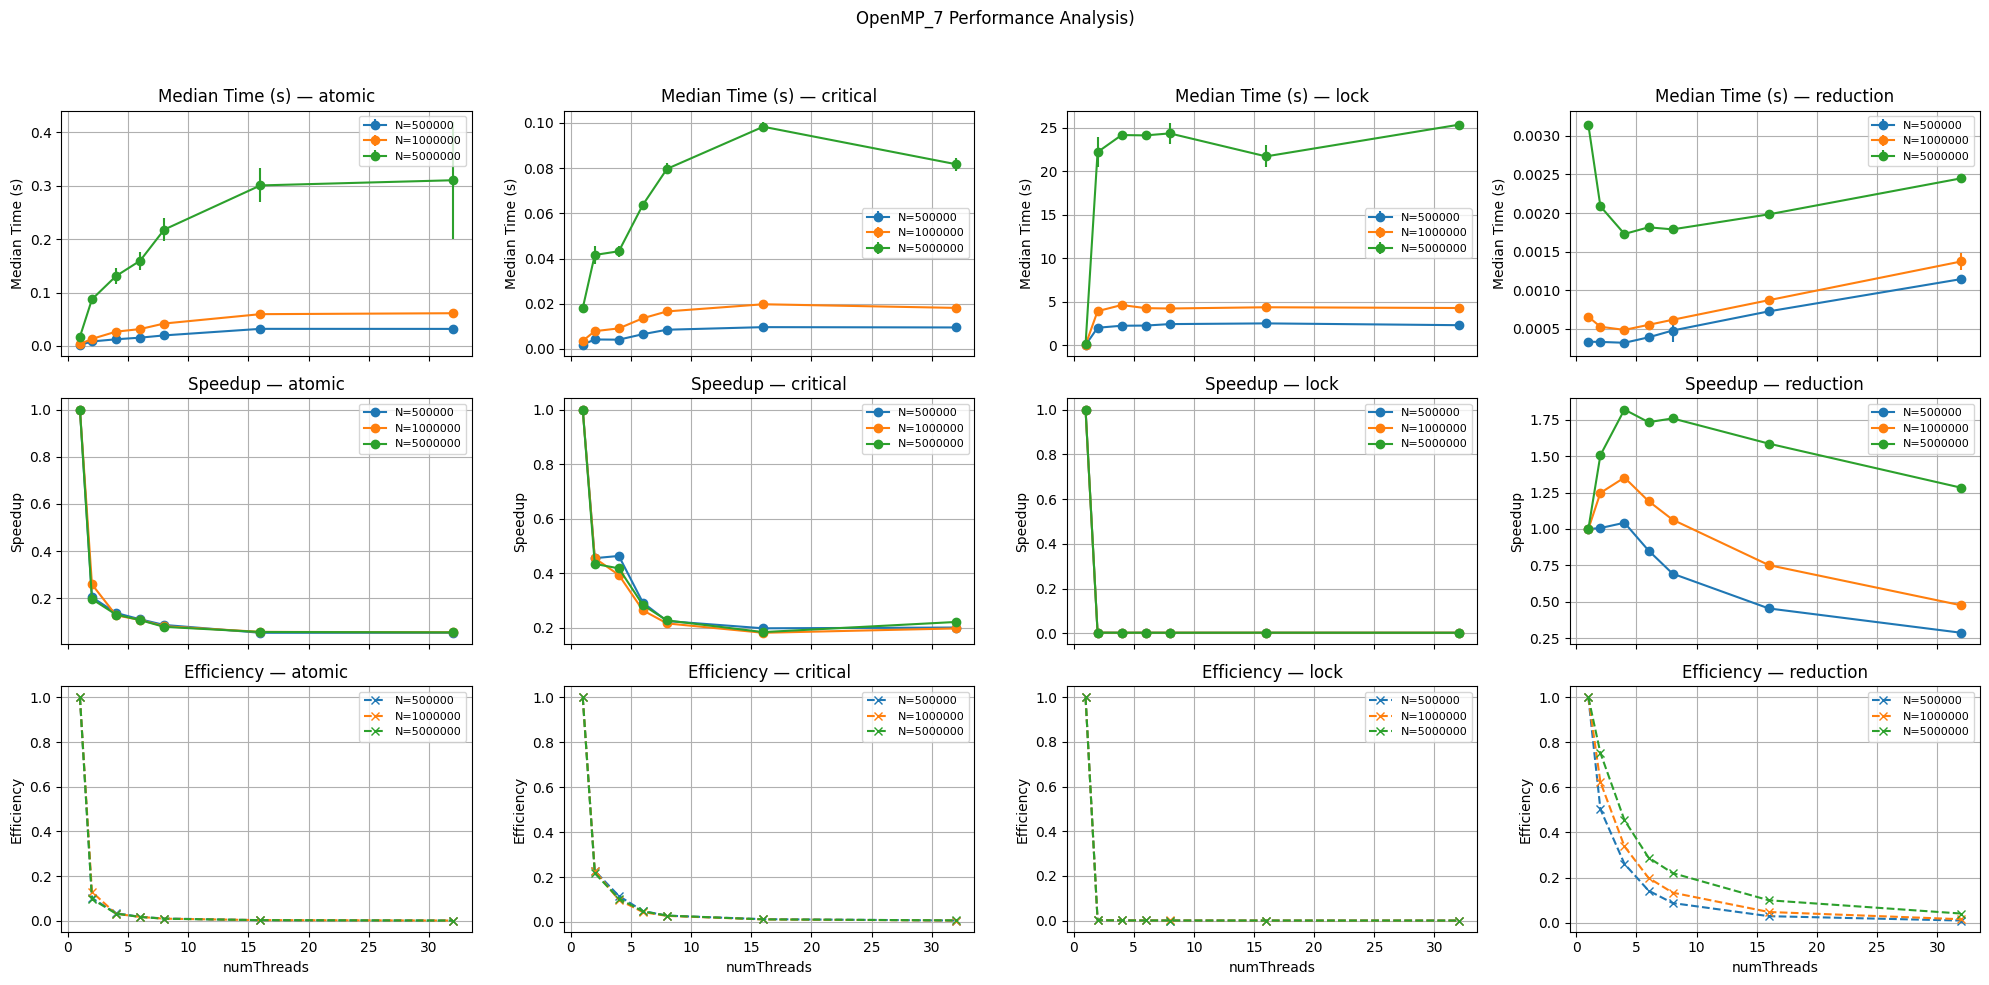

In [10]:
metrics = ["median", "speedup", "efficiency"]
metricLabels = {"median":"Median Time (s)", "speedup":"Speedup", "efficiency":"Efficiency"}

modes = sorted(perfFrame["mode"].unique())
problemSizeList = sorted(perfFrame["problemSize"].unique())

numCols = max(1, len(modes))
fig, axes = plt.subplots(len(metrics), numCols, figsize=(5 * numCols, 10), sharex=True)
if len(metrics) == 1 and numCols == 1:
    axes2d = np.array([[axes]])
elif len(metrics) == 1:
    axes2d = np.array([axes])
elif numCols == 1:
    axes2d = np.array([[ax] for ax in axes])
else:
    axes2d = axes

for colIdx, modeVal in enumerate(modes):
    for rowIdx, metric in enumerate(metrics):
        ax = axes2d[rowIdx][colIdx]
        subForMode = perfFrame[perfFrame["mode"] == modeVal]
        if subForMode.empty:
            ax.text(0.5, 0.5, 'no data', ha='center', va='center')
            ax.set_title(f"{modeVal}")
            ax.grid(True)
            continue

        for problemSizeVal in problemSizeList:
            subFrame = subForMode[subForMode["problemSize"] == problemSizeVal].sort_values("numThreads")
            if subFrame.empty:
                continue
            x = subFrame["numThreads"].values
            y = subFrame[metric].values
            if metric == "median":
                yerr = subFrame["std"].values
                ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"N={problemSizeVal}")
            else:
                linestyle = '-' if metric == 'speedup' else '--'
                markerStyle = 'o' if metric == 'speedup' else 'x'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"N={problemSizeVal}")

        ax.set_title(f"{metricLabels[metric]} — {modeVal}")
        if rowIdx == len(metrics) - 1:
            ax.set_xlabel('numThreads')
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=8)

plt.suptitle('OpenMP_7 Performance Analysis)')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [7]:
for modeVal in perfFrame["mode"].unique():
    sample = perfFrame[perfFrame["mode"] == modeVal]
    print(f"\n=== mode: {modeVal} — median time (s) ===")
    display(sample.pivot_table(index=["numThreads"], columns="problemSize", values="median"))
    print(f"\n=== mode: {modeVal} — speedup ===")
    display(sample.pivot_table(index=["numThreads"], columns="problemSize", values="speedup"))



=== mode: atomic — median time (s) ===


problemSize,500000,1000000,5000000
numThreads,,,
1,0.001712,0.003409,0.017122
2,0.008380,0.013171,0.087270
4,0.012430,0.026697,0.130780
6,0.015467,0.031551,0.159426
8,0.019717,0.041939,0.217668
16,0.031975,0.059464,0.300451
32,0.031878,0.061217,0.310146



=== mode: atomic — speedup ===


problemSize,500000,1000000,5000000
numThreads,,,
1,1.000000,1.000000,1.000000
2,0.204282,0.258834,0.196200
4,0.137724,0.127696,0.130924
6,0.110679,0.108050,0.107400
8,0.086825,0.081287,0.078662
16,0.053539,0.057331,0.056989
32,0.053702,0.055689,0.055207



=== mode: critical — median time (s) ===


problemSize,500000,1000000,5000000
numThreads,,,
1,0.001905,0.003578,0.018041
2,0.004189,0.007869,0.041595
4,0.004116,0.009102,0.043231
6,0.006532,0.013593,0.063800
8,0.008505,0.016610,0.079689
16,0.009652,0.019773,0.098345
32,0.009515,0.018169,0.081778



=== mode: critical — speedup ===


problemSize,500000,1000000,5000000
numThreads,,,
1,1.000000,1.000000,1.000000
2,0.454743,0.454682,0.433722
4,0.462852,0.393083,0.417308
6,0.291648,0.263215,0.282769
8,0.223992,0.215403,0.226388
16,0.197369,0.180940,0.183443
32,0.200223,0.196917,0.220605



=== mode: lock — median time (s) ===


problemSize,500000,1000000,5000000
numThreads,,,
1,0.006525,0.013196,0.06572
2,1.993230,3.901750,22.19610
4,2.223040,4.606660,24.15730
6,2.243060,4.247410,24.11630
8,2.411920,4.206810,24.34730
16,2.493280,4.348690,21.70160
32,2.288200,4.263240,25.33890



=== mode: lock — speedup ===


problemSize,500000,1000000,5000000
numThreads,,,
1,1.000000,1.000000,1.000000
2,0.003274,0.003382,0.002961
4,0.002935,0.002864,0.002721
6,0.002909,0.003107,0.002725
8,0.002705,0.003137,0.002699
16,0.002617,0.003034,0.003028
32,0.002852,0.003095,0.002594



=== mode: reduction — median time (s) ===


problemSize,500000,1000000,5000000
numThreads,,,
1,0.000330,0.000654,0.003143
2,0.000327,0.000524,0.002087
4,0.000316,0.000483,0.001728
6,0.000387,0.000549,0.001814
8,0.000475,0.000615,0.001788
16,0.000724,0.000869,0.001983
32,0.001143,0.001372,0.002450



=== mode: reduction — speedup ===


problemSize,500000,1000000,5000000
numThreads,,,
1,1.000000,1.000000,1.000000
2,1.006412,1.247519,1.506013
4,1.042708,1.352576,1.818981
6,0.852340,1.191144,1.732363
8,0.693749,1.063792,1.758138
16,0.455249,0.752331,1.585233
32,0.288364,0.476597,1.282677


In [9]:
summaryRows = []
for (modeVal, problemSizeVal), sub in perfFrame.groupby(["mode","problemSize"]):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestThreads = int(argMax["numThreads"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numThreads"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "mode": modeVal,
        "problemSize": problemSizeVal,
        "bestNumThreads": bestThreads,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Thread": medianAtOne
    })

summaryAnalysisFrame = pd.DataFrame(summaryRows).sort_values(["mode","problemSize"])
display(summaryAnalysisFrame)


,mode,problemSize,bestNumThreads,maxSpeedup,efficiencyAtBest,medianTime1Thread
0,atomic,500000,1,1.000000,1.000000,0.001712
1,atomic,1000000,1,1.000000,1.000000,0.003409
2,atomic,5000000,1,1.000000,1.000000,0.017122
3,critical,500000,1,1.000000,1.000000,0.001905
4,critical,1000000,1,1.000000,1.000000,0.003578
5,critical,5000000,1,1.000000,1.000000,0.018041
6,lock,500000,1,1.000000,1.000000,0.006525
7,lock,1000000,1,1.000000,1.000000,0.013196
8,lock,5000000,1,1.000000,1.000000,0.065720
9,reduction,500000,4,1.042708,0.260677,0.000330
